# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [88]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import re
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
#os.environ['CUDA_VISIBLE_DEVICES']='0,1'
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")



## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [89]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES= 5

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

## Create Model and Load Trained Weights

In [90]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
max =0
dirs = os.listdir(os.path.join(os.getcwd(),'../../logs/coco20180518T1056'))
freg = re.compile(r'_\d+')
for dir in dirs:
    number = freg.search(dir)
    if number is not None:
        if int(number.group()[1:])>int(max):
            max =number.group()[1:]
        
COCO_MODEL_PATH='/home/dev02/mask_rcnn/logs/coco20180518T1056/mask_rcnn_coco_'+max+'.h5'
model.load_weights(COCO_MODEL_PATH, by_name=True)

/home/dev02/mask_rcnn/logs/coco20180518T1056/mask_rcnn_coco_0022.h5


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [91]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

class_names=['BG','fork', 'knife', 'spoon','hotplate']



In [192]:
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            x = random.randint(x1, (x1 + x2) // 2)
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

def find_index_of_class(class_ids,class_to_find):
    '''
    find all the index in class_ids given class_to_fidn
    '''
    r = []
    for idx,i in enumerate(class_ids):
        if i == class_to_find:
            r.append(idx)      
    return r
        
def get_area_of_object(mask,index):
    '''get area with the equivalent index'''
    return np.sum(mask[:,:,index])

def find_highest_score(scores,class_indexes):
    max_index = scores[0]
    for i in class_indexes:
        if scores[i] > max:
            max_index = scores[i]
    return max_index

def find_highest_iou(masks,hotplate_index,other_objects_index):
    '''
    count all the 1 that union from 2 mask
    '''
    hotplate_mask=masks[:,:,hotplate_index[0]]
    highest_index = other_objects_index[0]
    max_union_score = 0
    union_score=0
    object_shape = hotplate_mask.shape
    for i in other_objects_index:
        object_mask = masks[:,:,i]
#         union_score = np.sum([list(filter(lambda x: x in hotplate_mask, sublist)) for sublist in object_mask])
        for l in range(object_shape[0]):
            for k in range(object_shape[1]):
#                 print(hotplate_mask[l,k],object_mask[l,k])
                if object_mask[l,k]==1 and hotplate_mask[l,k] ==1:
                    union_score +=1
        if union_score >max_union_score :
            highest_index = i
    return highest_index
                    
                    
        

        
def get_ratio(r):
    
    '''
    compare the ratio between hotplate and object
    requirements:
    - get the higest score of hotplaet
    - get the object in side bounding box of hotplate
    - count all the pixels
    
    pipeline:
    find the area of hot plate
    
    find the most union object with hotplate
    get area of that hotplate
    
    '''
 
    rois = r['rois']
    masks = r['masks'].astype(int)
    class_ids = r['class_ids']
    scores = r['scores']
    if len(class_ids) <=1:
        print('not enough object to compute')
        return None
    else:
        hotplate_index = find_index_of_class(class_ids, 4)
        other_objects_index = list(set(range(len(class_ids)))-set(hotplate_index))                               
        # if there is no hotplate 
        if len(hotplate_index) == 0:
            return None
        # if detect more than 1 hotplate
        if len(hotplate_index)>1 :
            hotplate_index = find_highest_score(scores,hotplate_index)
        object_index= find_highest_iou(masks,hotplate_index,other_objects_index)
        #compute area
        hotplate_area = get_area_of_object(masks,hotplate_index)
        object_area = get_area_of_object(masks,object_index)
    
        return hotplate_area/object_area
    
    

## Run Object Detection

Processing 1 images
image                    shape: (1024, 768, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
81.87440381558028


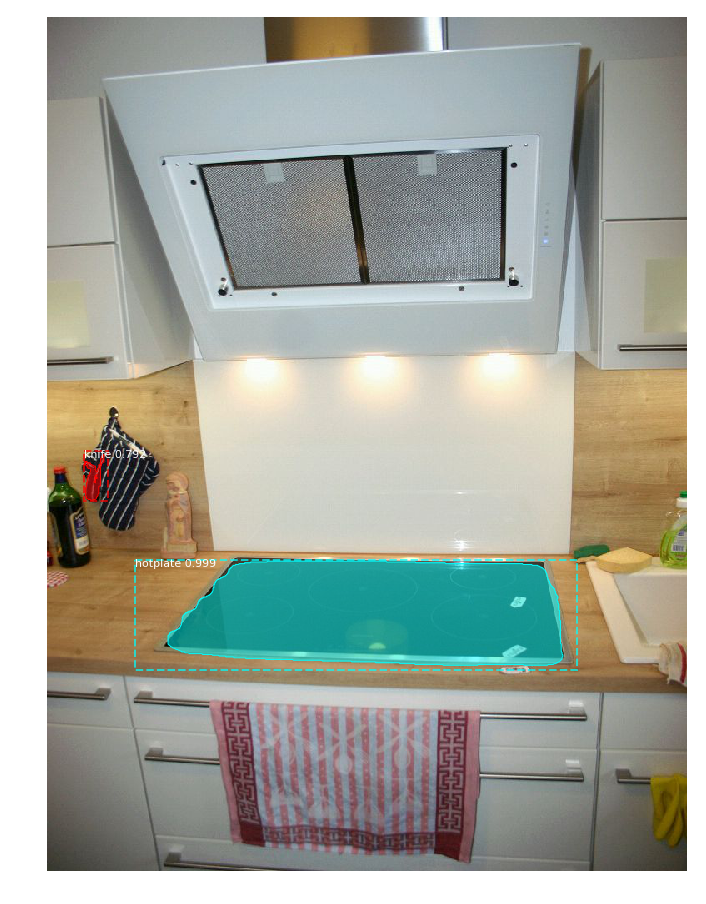

In [197]:
# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

#image to test : use from test1-10
image = skimage.io.imread('/home/dev02/mask_rcnn/test_images/test1.jpg')

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]

#testing
# print(image.shape)
# print(r['masks'].shape)
# np.savetxt('mask.txt',r['masks'][:,:,0],fmt='%d',delimiter=',')
# # print(r['masks'][:,:,1])


# nx,ny,nz=np.shape(r['masks'])
# CXY=np.zeros([ny, nx])
# for i in range(ny):
#     for j in range(nx):
#         CXY[i,j]=np.max(r['masks'][j,i,:])

# #Human readable data
# np.savetxt('masks.txt', CXY,fmt='%d',delimiter=',')
print(get_ratio(r))

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])